In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [56]:
import seaborn as sns

In [57]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [80]:
import LB_colony_growth.LB_colony_growth as lb

import skimage as ski
import skimage.draw

In [81]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 128
ny = 128

velocity_set = 'D2Q9'

In [92]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [93]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:halo, :] = lb.WALL_NODE
bc_map[-halo:, :] = lb.WALL_NODE
bc_map[:, 0:halo] = lb.WALL_NODE
bc_map[:, -halo:] = lb.WALL_NODE

In [94]:
R0 = 10

[r, c] = ski.draw.circle(nx/2, ny/2, R0)

rand_alleles = np.random.randint(-num_alleles, 0, size=(nx, ny))

In [95]:
bc_map[r, c] = rand_alleles[r, c]

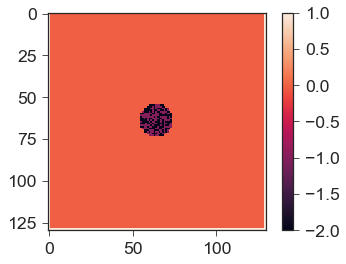

In [96]:
plt.imshow(bc_map)
plt.colorbar()

In [97]:
# Initialize rho...one everywhere, except in the circle where cells were inoculated

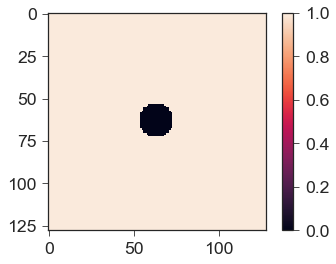

In [98]:
rho = np.ones((nx, ny), dtype=lb.num_type)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

rho[bc_in_domain < 0] = 0

plt.imshow(rho)
plt.colorbar()

In [99]:
m0 = 1.0

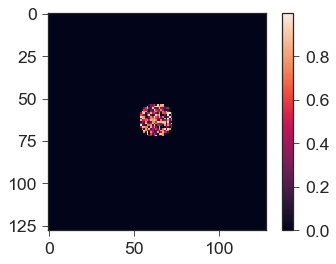

In [101]:
# Initialize the current amount of absorbed mass randomly

absorbed_mass = np.random.rand(nx, ny)
bc_in_domain = bc_map[halo:-halo, halo:-halo]

absorbed_mass[bc_in_domain >= 0] = 0

plt.imshow(absorbed_mass)
plt.colorbar()

In [102]:
k_list = [.01, .01]
m_reproduce_list = [m0, m0]
velocity_set = 'D2Q9'
D = .5 * (1./3.)

In [104]:
dla_colony = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set='D2Q9',
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list,
    absorbed_mass=absorbed_mass)

global size: (128, 128)
local size: (32, 16)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 9.0.282
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1594 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024L, 1024L, 64L]
---------------------------
This context is associated with  1 devices
tau 0.9999999999999998
omega 1.0000000000000002
global_size_bc: (160, 144)
Connecting python to the opencl_kernel init_feq...
[<pyopencl.cffi_cl.CommandQueue object at 0x7f849b5c4dd0>, (128, 128), (32, 16), <pyopencl.cffi_cl.Buffer object at 0x7f849b6b0c90>, <pyopencl.cffi_cl.Buffer object at 0x7f849b6b0e50>, <pyopencl.cffi_cl.Buffer object at 0x7f849b676410>, 9]
Connecting python to the opencl_kernel collide_and_propagate...


LB_colony_growth/LB_colony_growth.py:521: UserWarning: Received OpenCL source code in Unicode, should be ASCII string. Attempting conversion.
  


KeyError: 'local_mem_num'

In [75]:
np.random.randn(*(1, 2, 3))

array([[[ 0.25251241,  2.03035703,  0.28634894],
        [-0.14720688, -0.32646615, -1.32943847]]])

In [14]:
dla_colony.kernel_args

{'D': 0.16666666666666666,
 'bc_map': <pyopencl.cffi_cl.Buffer at 0x7ff25d0241d0>,
 'bc_map_streamed': <pyopencl.cffi_cl.Buffer at 0x7ff25d024290>,
 'buf_nx': 34,
 'buf_ny': 18,
 'buf_nz': None,
 'c_mag': <pyopencl.cffi_cl.Buffer at 0x7ff25cfeba90>,
 'c_vec': <pyopencl.cffi_cl.Buffer at 0x7ff2692fb310>,
 'cs': 0.57735026918962584,
 'f': <pyopencl.cffi_cl.Buffer at 0x7ff25d024410>,
 'f_streamed': <pyopencl.cffi_cl.Buffer at 0x7ff25d024490>,
 'feq': <pyopencl.cffi_cl.Buffer at 0x7ff25d024390>,
 'halo': 1,
 'k_list': <pyopencl.cffi_cl.Buffer at 0x7ff260f65590>,
 'm_reproduce_list': <pyopencl.cffi_cl.Buffer at 0x7ff260f65610>,
 'nx_bc': 130,
 'ny_bc': 130,
 'nz_bc': None,
 'omega': 1.0000000000000002,
 'reflect_index': <pyopencl.cffi_cl.Buffer at 0x7ff25cfeba50>,
 'rho': <pyopencl.cffi_cl.Buffer at 0x7ff25d024210>,
 'slip_index': <pyopencl.cffi_cl.Buffer at 0x7ff25d0240d0>,
 'tau': 0.99999999999999978}

In [24]:
flerp = dla_colony.ctx_info['kernel_arguments']['collide_and_propagate']

In [27]:
flerp

[['bc_map', '__global __read_only int *bc_map_global'],
 ['nx_bc', 'const int nx_bc'],
 ['ny_bc', 'const int ny_bc'],
 ['f', '__global double *f_global'],
 ['f_streamed', '__global double *f_streamed_global'],
 ['feq', '__global __read_only double *feq_global'],
 ['rho', '__global double *rho_global'],
 ['absorbed_mass', '__global double *absorbed_mass_global'],
 ['local_mem_num', '__local double *rho_local'],
 ['local_mem_int', '__local double *bc_map_local'],
 ['buf_nx', 'const int buf_nx'],
 ['buf_ny', 'const int buf_ny'],
 ['k_list', '__constant double *k'],
 ['D', 'const double D'],
 ['num_jumpers', 'const int num_jumpers'],
 ['omega', 'const double omega'],
 ['c_vec', '__constant int *c_vec'],
 ['c_mag', '__constant double *c_mag'],
 ['w', '__constant double *w'],
 ['reflect_list', '__constant double *reflect_list']]

In [26]:
[z[0] for z in flerp]

['bc_map',
 'nx_bc',
 'ny_bc',
 'f',
 'f_streamed',
 'feq',
 'rho',
 'absorbed_mass',
 'local_mem_num',
 'local_mem_int',
 'buf_nx',
 'buf_ny',
 'k_list',
 'D',
 'num_jumpers',
 'omega',
 'c_vec',
 'c_mag',
 'w',
 'reflect_list']